# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 17:43 - loss: 0.6942

  38/1875 [..............................] - ETA: 2s - loss: 0.5227   

  68/1875 [>.............................] - ETA: 2s - loss: 0.4544

 101/1875 [>.............................] - ETA: 2s - loss: 0.4131

 134/1875 [=>............................] - ETA: 2s - loss: 0.3864

 166/1875 [=>............................] - ETA: 2s - loss: 0.3675

 198/1875 [==>...........................] - ETA: 2s - loss: 0.3526

 234/1875 [==>...........................] - ETA: 2s - loss: 0.3390

 261/1875 [===>..........................] - ETA: 2s - loss: 0.3303

 288/1875 [===>..........................] - ETA: 2s - loss: 0.3226

 320/1875 [====>.........................] - ETA: 2s - loss: 0.3145

 351/1875 [====>.........................] - ETA: 2s - loss: 0.3076

 386/1875 [=====>........................] - ETA: 2s - loss: 0.3006

 417/1875 [=====>........................] - ETA: 2s - loss: 0.2950

 448/1875 [======>.......................] - ETA: 2s - loss: 0.2898

 483/1875 [======>.......................] - ETA: 2s - loss: 0.2845

 517/1875 [=======>......................] - ETA: 2s - loss: 0.2798

 551/1875 [=======>......................] - ETA: 2s - loss: 0.2754

 587/1875 [========>.....................] - ETA: 2s - loss: 0.2711

 621/1875 [========>.....................] - ETA: 1s - loss: 0.2674

 654/1875 [=========>....................] - ETA: 1s - loss: 0.2639

 692/1875 [==========>...................] - ETA: 1s - loss: 0.2602

 736/1875 [==========>...................] - ETA: 1s - loss: 0.2562

 781/1875 [===========>..................] - ETA: 1s - loss: 0.2524

 820/1875 [============>.................] - ETA: 1s - loss: 0.2493

 858/1875 [============>.................] - ETA: 1s - loss: 0.2464

 903/1875 [=============>................] - ETA: 1s - loss: 0.2433

 948/1875 [==============>...............] - ETA: 1s - loss: 0.2403

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2377

1027/1875 [===============>..............] - ETA: 1s - loss: 0.2354

1070/1875 [================>.............] - ETA: 1s - loss: 0.2329

1116/1875 [================>.............] - ETA: 1s - loss: 0.2304

1161/1875 [=================>............] - ETA: 1s - loss: 0.2281

1206/1875 [==================>...........] - ETA: 0s - loss: 0.2259

1243/1875 [==================>...........] - ETA: 0s - loss: 0.2241

1289/1875 [===================>..........] - ETA: 0s - loss: 0.2220

1329/1875 [====================>.........] - ETA: 0s - loss: 0.2203

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2184

1413/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1453/1875 [======================>.......] - ETA: 0s - loss: 0.2152

1494/1875 [======================>.......] - ETA: 0s - loss: 0.2137

1540/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1585/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1625/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1661/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1739/1875 [==========================>...] - ETA: 0s - loss: 0.2054

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1824/1875 [============================>.] - ETA: 0s - loss: 0.2029

1862/1875 [============================>.] - ETA: 0s - loss: 0.2018

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2014


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1132

  42/1875 [..............................] - ETA: 2s - loss: 0.1088

  85/1875 [>.............................] - ETA: 2s - loss: 0.1097

 124/1875 [>.............................] - ETA: 2s - loss: 0.1097

 162/1875 [=>............................] - ETA: 2s - loss: 0.1096

 200/1875 [==>...........................] - ETA: 2s - loss: 0.1095

 241/1875 [==>...........................] - ETA: 2s - loss: 0.1095

 280/1875 [===>..........................] - ETA: 2s - loss: 0.1094

 320/1875 [====>.........................] - ETA: 1s - loss: 0.1093

 362/1875 [====>.........................] - ETA: 1s - loss: 0.1092

 402/1875 [=====>........................] - ETA: 1s - loss: 0.1091

 445/1875 [======>.......................] - ETA: 1s - loss: 0.1090

 491/1875 [======>.......................] - ETA: 1s - loss: 0.1089

 531/1875 [=======>......................] - ETA: 1s - loss: 0.1088

 568/1875 [========>.....................] - ETA: 1s - loss: 0.1087

 605/1875 [========>.....................] - ETA: 1s - loss: 0.1087

 643/1875 [=========>....................] - ETA: 1s - loss: 0.1086

 677/1875 [=========>....................] - ETA: 1s - loss: 0.1085

 722/1875 [==========>...................] - ETA: 1s - loss: 0.1084

 762/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 789/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 824/1875 [============>.................] - ETA: 1s - loss: 0.1082

 862/1875 [============>.................] - ETA: 1s - loss: 0.1081

 901/1875 [=============>................] - ETA: 1s - loss: 0.1081

 936/1875 [=============>................] - ETA: 1s - loss: 0.1080

 972/1875 [==============>...............] - ETA: 1s - loss: 0.1079

1004/1875 [===============>..............] - ETA: 1s - loss: 0.1079

1034/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1068/1875 [================>.............] - ETA: 1s - loss: 0.1078

1102/1875 [================>.............] - ETA: 1s - loss: 0.1077

1142/1875 [=================>............] - ETA: 0s - loss: 0.1076

1171/1875 [=================>............] - ETA: 0s - loss: 0.1076

1203/1875 [==================>...........] - ETA: 0s - loss: 0.1075

1239/1875 [==================>...........] - ETA: 0s - loss: 0.1074

1275/1875 [===================>..........] - ETA: 0s - loss: 0.1074

1300/1875 [===================>..........] - ETA: 0s - loss: 0.1073

1337/1875 [====================>.........] - ETA: 0s - loss: 0.1073

1382/1875 [=====================>........] - ETA: 0s - loss: 0.1072

1417/1875 [=====================>........] - ETA: 0s - loss: 0.1071

1440/1875 [======================>.......] - ETA: 0s - loss: 0.1071

1470/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1542/1875 [=======================>......] - ETA: 0s - loss: 0.1069

1585/1875 [========================>.....] - ETA: 0s - loss: 0.1068

1620/1875 [========================>.....] - ETA: 0s - loss: 0.1068

1656/1875 [=========================>....] - ETA: 0s - loss: 0.1067

1701/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1746/1875 [==========================>...] - ETA: 0s - loss: 0.1066

1781/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1811/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1838/1875 [============================>.] - ETA: 0s - loss: 0.1065

1873/1875 [============================>.] - ETA: 0s - loss: 0.1064

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1064


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1027

  39/1875 [..............................] - ETA: 2s - loss: 0.0993

  79/1875 [>.............................] - ETA: 2s - loss: 0.0992

 122/1875 [>.............................] - ETA: 2s - loss: 0.0991

 156/1875 [=>............................] - ETA: 2s - loss: 0.0990

 197/1875 [==>...........................] - ETA: 2s - loss: 0.0990

 242/1875 [==>...........................] - ETA: 2s - loss: 0.0990

 287/1875 [===>..........................] - ETA: 1s - loss: 0.0989

 332/1875 [====>.........................] - ETA: 1s - loss: 0.0989

 377/1875 [=====>........................] - ETA: 1s - loss: 0.0989

 417/1875 [=====>........................] - ETA: 1s - loss: 0.0988

 462/1875 [======>.......................] - ETA: 1s - loss: 0.0988

 506/1875 [=======>......................] - ETA: 1s - loss: 0.0988

 546/1875 [=======>......................] - ETA: 1s - loss: 0.0988

 580/1875 [========>.....................] - ETA: 1s - loss: 0.0988

 618/1875 [========>.....................] - ETA: 1s - loss: 0.0987

 663/1875 [=========>....................] - ETA: 1s - loss: 0.0987

 703/1875 [==========>...................] - ETA: 1s - loss: 0.0987

 743/1875 [==========>...................] - ETA: 1s - loss: 0.0987

 785/1875 [===========>..................] - ETA: 1s - loss: 0.0987

 827/1875 [============>.................] - ETA: 1s - loss: 0.0986

 867/1875 [============>.................] - ETA: 1s - loss: 0.0986

 902/1875 [=============>................] - ETA: 1s - loss: 0.0986

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0986

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0986

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0986

1082/1875 [================>.............] - ETA: 0s - loss: 0.0986

1130/1875 [=================>............] - ETA: 0s - loss: 0.0986

1178/1875 [=================>............] - ETA: 0s - loss: 0.0985

1225/1875 [==================>...........] - ETA: 0s - loss: 0.0985

1274/1875 [===================>..........] - ETA: 0s - loss: 0.0985

1315/1875 [====================>.........] - ETA: 0s - loss: 0.0985

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0985

1399/1875 [=====================>........] - ETA: 0s - loss: 0.0985

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0985

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0984

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0984

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0984

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0984

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0984

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0984

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0984

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0984

1844/1875 [============================>.] - ETA: 0s - loss: 0.0983

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0983


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0898

  49/1875 [..............................] - ETA: 1s - loss: 0.0953

  97/1875 [>.............................] - ETA: 1s - loss: 0.0955

 145/1875 [=>............................] - ETA: 1s - loss: 0.0957

 194/1875 [==>...........................] - ETA: 1s - loss: 0.0959

 244/1875 [==>...........................] - ETA: 1s - loss: 0.0961

 293/1875 [===>..........................] - ETA: 1s - loss: 0.0962

 341/1875 [====>.........................] - ETA: 1s - loss: 0.0963

 389/1875 [=====>........................] - ETA: 1s - loss: 0.0963

 436/1875 [=====>........................] - ETA: 1s - loss: 0.0964

 483/1875 [======>.......................] - ETA: 1s - loss: 0.0964

 530/1875 [=======>......................] - ETA: 1s - loss: 0.0964

 576/1875 [========>.....................] - ETA: 1s - loss: 0.0965

 623/1875 [========>.....................] - ETA: 1s - loss: 0.0965

 671/1875 [=========>....................] - ETA: 1s - loss: 0.0965

 717/1875 [==========>...................] - ETA: 1s - loss: 0.0965

 764/1875 [===========>..................] - ETA: 1s - loss: 0.0965

 809/1875 [===========>..................] - ETA: 1s - loss: 0.0966

 854/1875 [============>.................] - ETA: 1s - loss: 0.0966

 901/1875 [=============>................] - ETA: 1s - loss: 0.0966

 948/1875 [==============>...............] - ETA: 0s - loss: 0.0966

 995/1875 [==============>...............] - ETA: 0s - loss: 0.0966

1042/1875 [===============>..............] - ETA: 0s - loss: 0.0966



1088/1875 [================>.............] - ETA: 0s - loss: 0.0966

1135/1875 [=================>............] - ETA: 0s - loss: 0.0966

1184/1875 [=================>............] - ETA: 0s - loss: 0.0966

1233/1875 [==================>...........] - ETA: 0s - loss: 0.0966

1281/1875 [===================>..........] - ETA: 0s - loss: 0.0965

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0965

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0965

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0965

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0965

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0965

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0965

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0965

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1849/1875 [============================>.] - ETA: 0s - loss: 0.0965

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0965


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0912

  48/1875 [..............................] - ETA: 1s - loss: 0.0938

  95/1875 [>.............................] - ETA: 1s - loss: 0.0946

 142/1875 [=>............................] - ETA: 1s - loss: 0.0947

 190/1875 [==>...........................] - ETA: 1s - loss: 0.0949

 237/1875 [==>...........................] - ETA: 1s - loss: 0.0949

 285/1875 [===>..........................] - ETA: 1s - loss: 0.0950

 332/1875 [====>.........................] - ETA: 1s - loss: 0.0951

 380/1875 [=====>........................] - ETA: 1s - loss: 0.0951

 427/1875 [=====>........................] - ETA: 1s - loss: 0.0952

 474/1875 [======>.......................] - ETA: 1s - loss: 0.0952

 520/1875 [=======>......................] - ETA: 1s - loss: 0.0953

 566/1875 [========>.....................] - ETA: 1s - loss: 0.0953

 612/1875 [========>.....................] - ETA: 1s - loss: 0.0953

 661/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 710/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 757/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 804/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 851/1875 [============>.................] - ETA: 1s - loss: 0.0954

 898/1875 [=============>................] - ETA: 1s - loss: 0.0954

 945/1875 [==============>...............] - ETA: 0s - loss: 0.0954

 992/1875 [==============>...............] - ETA: 0s - loss: 0.0955

1039/1875 [===============>..............] - ETA: 0s - loss: 0.0955

1085/1875 [================>.............] - ETA: 0s - loss: 0.0955

1133/1875 [=================>............] - ETA: 0s - loss: 0.0955

1181/1875 [=================>............] - ETA: 0s - loss: 0.0955

1229/1875 [==================>...........] - ETA: 0s - loss: 0.0955

1278/1875 [===================>..........] - ETA: 0s - loss: 0.0955

1326/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1856/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0956


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

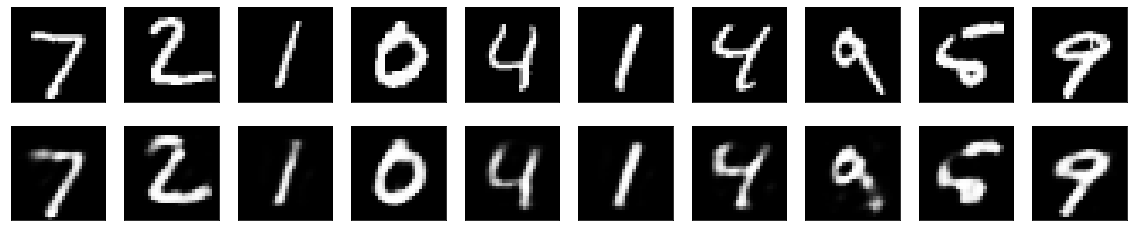

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
